In [1]:
import numpy as np
import string
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import pandas as pd
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import prince
sns.set_style('whitegrid')
import re
from collections import Counter

%matplotlib inline
from mpl_toolkits import mplot3d

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
from lemminflect import getLemma
import spacy
import lemminflect
from nltk import pos_tag
wordnet = WordNetLemmatizer()

## Prepossess Dataset

In [13]:
df = pd.read_excel('Copy of claires master file 3-6-20.xlsx')
df.head(1)

,manuscript number,Cluster,Poster,ID,Status,Abstract Title,Last Name,First Name,Abstract,Email Contact,...,Evaulator 2 Rating,Evaluator 2 Comments,Evaluator 3 Rating,Evaluator 3 Comments,Evaluator 4 Rating,Evaluator 4 Comments,Evaluator 5 Rating,Evaluator 5 Comments,Evaluator 6 Rating,Evaluator 6 Comments
0,NaN,23.0,P,2,Working Paper,CONSUMER AND PRODUCT SUCCESS PROFILE</b>,Kolosova,Tanya,Consumer and Product Profiles describe the att...,t.kolosova@yieldwise.com,...,2.0,NaN,3.0,There are no details as to how this approach h...,1,Reads like a promo-talk based on a tool with p...,NaN,NaN,NaN,NaN


In [14]:
df.columns

Index(['manuscript number', 'Cluster', 'Poster', 'ID', 'Status',
       'Abstract Title', 'Last Name', 'First Name', 'Abstract',
       'Email Contact', 'Topic1', 'Topic2', 'Topic3', 'Keyword1', 'Keyword2',
       'Keyword3', 'Evaulator 1 Rating', 'Evaluator 1 Comments',
       'Evaulator 2 Rating', 'Evaluator 2 Comments', 'Evaluator 3 Rating',
       'Evaluator 3 Comments', 'Evaluator 4 Rating', 'Evaluator 4 Comments',
       'Evaluator 5 Rating', 'Evaluator 5 Comments', 'Evaluator 6 Rating',
       'Evaluator 6  Comments'],
      dtype='object')

In [15]:
#Drop duplicated papers
df.ID[df.ID.duplicated()]

34       71
428    1714
432    1763
455    1909
Name: ID, dtype: int64

In [16]:
df = df.drop([34,428,432,455])

In [17]:
df.shape

(488, 28)

In [18]:
#Drop papers with Poster status == r or p
df.Poster.value_counts()

P    47
p     9
r     4
Name: Poster, dtype: int64

In [19]:
df = df[df.Poster != 'r']
df = df[df.Poster != 'p']
df = df[df.Poster != 'P']

In [20]:
df.shape

(428, 28)

In [21]:
#save ratings to a separate dataframe
ratings = df.iloc[:,-12::2]
ratings.head(5)

,Evaulator 1 Rating,Evaulator 2 Rating,Evaluator 3 Rating,Evaluator 4 Rating,Evaluator 5 Rating,Evaluator 6 Rating
1,2,3.0,NaN,NaN,NaN,NaN
2,4,3.0,NaN,NaN,NaN,NaN
4,4,3.0,NaN,NaN,NaN,NaN
5,3,1.0,NaN,3,NaN,NaN
6,3,2.0,NaN,NaN,NaN,NaN


In [26]:
#check abnormal ratings
ratings.iloc[[12,34],:]

,Evaulator 1 Rating,Evaulator 2 Rating,Evaluator 3 Rating,Evaluator 4 Rating,Evaluator 5 Rating,Evaluator 6 Rating
16,3,5.0,NaN,1 or 4,NaN,NaN
41,**5**,5.0,NaN,3,NaN,NaN


In [27]:
ratings.iloc[34,0] = 5
ratings.iloc[12,3] = 4

In [29]:
#transform all rating dtype to numeric and get the mean rating for each paper
ratings_num = ratings.copy()
ratings_num['Evaulator 1 Rating'] = pd.to_numeric(ratings['Evaulator 1 Rating'])
ratings_num['Evaulator 2 Rating'] = pd.to_numeric(ratings['Evaulator 2 Rating'])
ratings_num['Evaluator 3 Rating'] = pd.to_numeric(ratings['Evaluator 3 Rating'])
ratings_num['Evaluator 4 Rating'] = pd.to_numeric(ratings['Evaluator 4 Rating'])
ratings_num['Evaluator 5 Rating'] = pd.to_numeric(ratings['Evaluator 5 Rating'])
ratings_num['Evaluator 6 Rating'] = pd.to_numeric(ratings['Evaluator 6 Rating'])
ratings_num['mean'] = ratings_num.mean(axis=1,skipna = True)

In [30]:
ratings_num['ID'] = df.iloc[:,3]
ratings_mean = ratings_num[['ID','mean']]

In [31]:
df_new = df.copy()
df_new['mean_rating'] = ratings_num['mean']
df_new.head(1)

,manuscript number,Cluster,Poster,ID,Status,Abstract Title,Last Name,First Name,Abstract,Email Contact,...,Evaluator 2 Comments,Evaluator 3 Rating,Evaluator 3 Comments,Evaluator 4 Rating,Evaluator 4 Comments,Evaluator 5 Rating,Evaluator 5 Comments,Evaluator 6 Rating,Evaluator 6 Comments,mean_rating
1,NaN,20.0,NaN,13,NaN,Risk And Time Preferences For Consumersâ€™ Cho...,Zhu,Jingrong,Mass penetration of electric vehicles into the...,13164200416@163.com,...,Speaks to an interesting technology adoption i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5


In [35]:
#prepare dataframe for clustering 
df1 = pd.DataFrame(np.c_[df.iloc[:,3],df.iloc[:,5],df.iloc[:,8],df.iloc[:,10:16]])
df1.columns = ['ID','Title','Abstract','Topic1','Topic2','Topic3','Keyword1','Keyword2','Keyword3']
df1.head()

,ID,Title,Abstract,Topic1,Topic2,Topic3,Keyword1,Keyword2,Keyword3
0,13,Risk And Time Preferences For Consumersâ€™ Cho...,Mass penetration of electric vehicles into the...,Content - Decision-Making: Uncertainty,Content - Consumer Behavior: Preferences,Method - Survey Research: General,NaN,NaN,NaN
1,16,How To Overcome Online Banner Blindness? A Stu...,Creativity matters for attracting consumer att...,Content - Advertising: Consumer Response,Content - Digital Marketing: Banner Advertising,Content - Consumer Behavior: Perception,Advertising Creative,Online Advertising,Eye-Tracking Data
2,20,Research On The Influence Of Digital Presentat...,This experiment uses 2 (digital presentation f...,Content - Brands: General,Content - Brands: Brand Equity,Social Media – Viral Marketing,Branding,Brand Switching,Brand Equity
3,23,Research On The Influence Of Marketing Capabil...,Whether firms' marketing capability predicts f...,Marketing and Finance,Content - Marketing Interface: with Finance,Method - Experimental Research: General,Firm Performance,Resource Allocation,Endogeneity
4,25,Adopting Cost Transparency As A Marketing Stra...,Should sellers disclose their cost information...,Content - Marketing Strategy: General,Behavioral Games: General,Content - Pricing: Competition,Pricing,Behavioral Economics,Experimental Economics


In [36]:
df2 = df1.replace(np.nan, '', regex=True)

## Data Cleaning

In [42]:
def replace_term(data):
    """
    Transform some terms to their abbreviation
    """
    data1 = data.replace('game theory','gt').replace('game theorical','gt').replace('game-theorical','gt')
    data2 = data1.replace('machine learning','ml').replace('machine-learning','ml')
    data3 = data2.replace('neural networks','nn').replace('neural network','nn').replace('neural-network','nn')
    data4 = data3.replace('word of mouth','wom').replace('wordofmouth','wom').replace('word-of-mouth','wom')
    data5 = data4.replace('analytical models','anam').replace('analytical model','anam').replace('replationship','relationship')
    data6 = data5.replace('social media','sm').replace('consumer loss aversion','cla')
    data7 = data6.replace('structural model','smodel').replace('structural models','smodel')
    data8 = data7.replace('competitive analysis','ca').replace('corporate social responsibility','csr')
    data9 = data8.replace('artifical intelligence','ai').replace('industrial organization','io')
    data10 = data9.replace('consumer behavior','cb').replace('panel data','pdata').replace('ads','ad')
    data11 = data10.replace('behavioral economics','bhe').replace('high fashion','high-fashion').replace('bag of words','bow').replace('bag-of-words','bow')
    data12 = data11.replace('business-to-business','btob').replace('b2b','btob').replace('business to business','btob')
    data13 = data12.replace('difference-in-difference','did').replace('advertiser','advertising')
    data14 = data13.replace('high-dimensional','hd').replace('high dimension','hd').replace('high dimensionality','hd').replace('high-dimension','hd')
    data15 = data14.replace('big data','bd').replace('algorithms','algorithm').replace(
    'in group','in-group').replace('ingroup','in-group').replace('low involvement',
    'low-involvement').replace('markovian','markov').replace('methodologically','methodology').replace(
    'Monte Carlo','montecarlo').replace('nonlinear','non-linear').replace('out group','out-group').replace(
    'pay to listen','pay-to-listen').replace('product labeling','product-labeling').replace('ridesharing','ride-sharing').replace(
    'single dimensional','single-dimensional').replace('within brand','within-brand').replace('within channel','within-channel')
    
    return data15

In [43]:
def lemma(data):
    """
    Manually lemmatize words(based on the vocabulary you got)
    """
    data_1 = data.replace('behavioural','behavioral').replace('bidding','bid').replace(
    'bottom ranked','bottom-ranked').replace('ceos','ceo').replace('chinese','china').replace(
    'continuous time','continuous-time').replace('exogenously','exogenous').replace(
        'endogenously','endogenous').replace('brings','bring').replace('cbs','cb').replace('clustered','cluster').replace(
        'concludes','conclude').replace('creates','create').replace('enhances','enhance').replace('facilitates','facilitate').replace(
    'forwarders','forwarder').replace('indicates','indicate').replace('integrates','integrate').replace('introduces','introduce').replace('learns','learn').replace(
   'lockout.','lockout').replace('misspecifications','misspecification').replace('modelling','modeling').replace('non-profits',"non-profit").replace(
    'occurs','occur').replace('proposes','propose').replace('proﬁts','proﬁt').replace('retailer-brands','retailer-brand').replace('smodels','smodel').replace(
    'trade-off','tradeoff').replace('surveys','survey').replace('relationships','replationship').replace('products','product').replace('methods','method').replace(
        'innovations','innovation').replace('website','web').replace('analytics','analytic').replace('channels','channel').replace('econometrics','econometric').replace(
    'multichannels','multichannel').replace('womreviews','wom').replace('adopters','adopter').replace('promotions','promotion').replace(
    'adoptions','adoption').replace('ads','ad').replace('advertisement','ad').replace('advertisements','ad').replace('advertise','ad').replace(
        'advertisers','advertiser').replace('attitudes','attitude').replace('attributes','attribute').replace('audiences','audience').replace(
    'behaviors','behavior').replace('behaviour','behavior').replace('bidders','bidder').replace('biases','bias').replace('bids','bid').replace(
    'borrowers','borrower').replace('brands','brand').replace('budgets','budget').replace('businesses','business').replace('buyers','buyer').replace(
    'campaigns','campaign').replace('categories','category').replace('chains','chain').replace('choices','choice').replace('clicks','click')
    
    data_2 = data_1.replace('clusters','cluster').replace('communications','communication').replace('communities','community').replace('companies','company').replace('comparisons','comparison').replace('competitors','competitor').replace('configurations','configuration').replace('consumers','consumer').replace('constructs','construct').replace('contexts','context').replace('contracts','contract').replace('costs','cost').replace('coupons','coupon').replace('creators','creator').replace('credits','credit').replace('crowds','crowd').replace('customers','customer').replace('decisions','decision').replace('designs','design').replace('dimensions','dimension').replace('discounts','discount').replace('documents','document').replace('donations','donation').replace('elasticities','elasticity').replace('embeddings','embedding').replace('emotions','emotion').replace('entrepreneurs','entrepreneur').replace('environments','environment').replace('estimations','estimation').replace('evidences','evidence').replace('experiences','experience').replace('experiments','experiment').replace('factors','factor').replace('fans','fan').replace('features','feature').replace('fields','field').replace('firms','firm').replace('followers','follower').replace('frameworks','framework').replace('franchising','franchise').replace('gains','gain').replace('games','game').replace('groups','group').replace('hypotheses','hypothesis').replace('identities','identity').replace('images','image').replace('incentives','incentive').replace('individuals','individual').replace('industries','industry').replace('inferences','inference').replace('influencers','influencer').replace('intentions','intention').replace('interactions','interaction')
    
    data_3 = data_2.replace('investments','investment').replace('investors','investor').replace('levels','level').replace('literatures','literature').replace('loans','loan').replace('manipulations','manipulation').replace('manufacturers','manufacturer').replace('markets','market').replace('mechanisms','mechanism').replace('messages','message').replace('marketers','marketer').replace('models','model').replace('motivations','motivation').replace('movies','movie').replace('networks','network').replace('organizations','organization').replace('parameters','parameter').replace('participants','participant').replace('patterns','pattern').replace('payments','payment').replace('peers','peer').replace('perceptions','perception').replace('periods'
    ,'period').replace('pictures','picture').replace('players','player').replace('policies','policy').replace('portfolios','portfolio').replace('posts','post').replace('practices','practice').replace('predictions','prediction').replace('preferences','preference').replace('prices'
    ,'price').replace('profits','profit').replace('promotions','promotion').replace('providers','provider').replace('purchases','purchase').replace('rankings','ranking').replace('ratings','rating').replace('recalls','recall').replace('recommendations','recommendation').replace('regressions'
    ,'regression').replace('regulations','regulation').replace('responses','response').replace('restaurants','restaurant').replace('retailers','retailer').replace('returns','return').replace('revenues','revenue').replace('rewards','reward').replace('risks','risk').replace(
    'roles','role').replace('sales','sale').replace('scales','scale').replace('scores','score').replace('segments','segment').replace('sellers','seller').replace('sentiments','sentiment').replace('services','service').replace(
    'shareholders','shareholder').replace('simulations','simulation').replace('situations','situation').replace('spaces','space').replace(
    'startups','startup').replace('stores','store').replace('strategies','strategy').replace('streams','streaming').replace('stream','streaming').replace('structures','structure').replace(
    'suppliers','supplier').replace('tasks','task').replace('technologies','technology').replace('tests','test').replace(
    'texts','text').replace('theories','theory').replace('topics','topic').replace('transactions','transaction').replace('trends','trend').replace(
    'trips','trip').replace('users','user').replace('utilities','utility').replace('variables','variable').replace('videos','video').replace(
    'views','view').replace('volumes','volume').replace('webs','web')
    
    return data_2

In [44]:
def transform(data):
    
    data_output = data.replace('strategies','strategy').replace('structures','structure').replace(
        'stores','store').replace('services','service').replace('sales','sale').replace('retailers','retailer').replace(
    'recommendations','recommendation').replace('recalls','recall').replace('recalling','recall').replace(
        'purchases','purchase').replace('auctions','auction').replace('economies','economy').replace(
        'entrepreneurhip','entrepreneur').replace('investors','investor').replace('monte carlo','mc').replace(
        'monte-carlo','mc').replace('movies','movie').replace('networks','network').replace('patterns','pattern').replace(
    'perceptions','perception').replace('platforms','platform').replace('policies','policy').replace(
        'preferences','preference').replace('prices','price').replace('providers','provider').replace(
        'replationship','relationship').replace('returns','return').replace('risks','risk').replace(
        'technologies','technology').replace('users','user').replace('utilities','utility').replace(
    'branding','brand').replace('financing','finance').replace('hotelling','hotels').replace('models','model').replace(
    'payment','pay').replace('pricing','price').replace('retailer','retailing').replace('tourists','tourism').replace(
    'monopolist','monopoly').replace('platforms','platform').replace('coupons','coupon').replace(
        'experimentation','experiment').replace('adopter','adoption')
    
    return data_output

## Create Corpora

### Obtain corpus for keywords

In [47]:
Keywords = df2.Keyword1+' ' +df2.Keyword2+' '+df2.Keyword3
Topics = df2.Topic1+' ' +df2.Topic2+' '+df2.Topic3
kstr = [','.join(w.translate(str.maketrans('', '', string.punctuation)).splitlines()).replace('and ','').replace('Marketing','').replace('marketing','')
        .lstrip()
              for w in Keywords.values if type(w) is str]
tstr = [','.join(w.translate(str.maketrans('', '', string.punctuation)).splitlines()).replace('and ','').replace('Marketing','').replace('marketing','').lstrip() 
              for w in Topics.values if type(w) is str]

tstr = [re.sub(' +', ' ', w) for w in tstr]

In [40]:
str_pd = pd.DataFrame(tstr) + ' ' + pd.DataFrame(kstr)
str_pd.columns = ['key']
str_pd['ID'] =list(df1.ID)
str_pd.tail(3)

,key,ID
425,Method Structural Equation Modeling General Co...,1919
426,Content Digital Web Analytics Social Media – V...,1927
427,Content Advertising General Content Digital Ge...,1968


In [45]:
keywords = list(str_pd.key)
key = [lemma(replace_term(doc.lower())) for doc in keywords]
key = [transform(item) for item in key]

In [46]:
#remove stopwords and tokenize
stop = stopwords.words('english')
punctuations = list(string.punctuation)
extras = ['–']
stop_words = stop+punctuations+extras
keyword_lemma = [wordnet.lemmatize(keyword.lower()) for keyword in key]
keyword_docs = [word_tokenize(doc) for doc in keyword_lemma]
keyword_docs = [word for word in keyword_docs if word not in stop_words]

In [48]:
#key_vocabulary.csv contains manually selected 219 words from keywords vocabulary
key_vocabulary = pd.read_csv('key_vocabulary.csv')
key_voc = list(key_vocabulary.iloc[:,1])
keywords = [[word for word in doc if word in key_voc] for doc in keyword_docs]

In [49]:
key_new = {}
for i in range(len(keywords)):
    key_new[i] = ' '.join(keywords[i])

In [50]:
key_dict = {}
for i in range(len(keywords)):
    key_dict[i] = word_tokenize(key_new[i])

In [51]:
key_dict_str = {}
for i in range(len(key_dict)):
    key_dict_str[i] = ' '.join(key_dict[i]) 

In [52]:
key_frame = pd.DataFrame.from_dict(key_dict_str,orient = 'index',columns = ['keywords'])
key_frame['ID'] = list(df2.ID)
key_frame.head()

,keywords,ID
0,decisionmaking uncertainty cb survey,13
1,advertising consumer response digital banner a...,16
2,brequity sm viral brswitching brequity,20
3,finance interface finance experimental firm pe...,23
4,strategy behavioral competition bhe experiment...,25


In [53]:
def tokenize_func(data):
    tokenized = [word_tokenize(doc) for doc in data]
    # Remove numbers, but not words that contain numbers.
    token_nodigit = [[token for token in doc if not token.isdigit()] for doc in tokenized]
    # Remove words that are only one character.
    tokenized_clean = [[token for token in doc if len(token) > 1] for doc in token_nodigit] 
    docs_lemma = [[wordnet.lemmatize(word) for word in doc] for doc in tokenized_clean]
    
    return docs_lemma

In [54]:
key_set = {}
for i in range(len(keywords)):
    key_set[i] = list(set(word_tokenize(key_new[i])))

### Obtain corpus for titles

In [63]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjs.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [67]:
#for titles, we only consider nouns
title_doc = list(df2.Title)
title =[replace_term(doc.lower()) for doc in title_doc]
title = [lemma(doc.lower()).replace('ads','ad').replace('acquisitions','acquisition').replace('advertisings','advertising').replace('advertising','ad') for doc in title]
title = [transform(doc) for doc in title]
title_nouns = [nouns(item) for item in title]

In [68]:
#remove stopwords and tokenize
stop = stopwords.words('english')
punctuations = list(string.punctuation)
extras = ['–']
stop_words = stop+punctuations+extras
title_lemma = [wordnet.lemmatize(item.lower()) for item in title_nouns]
title_docs = [word_tokenize(doc) for doc in title_lemma]
title_docs = [word for word in title_docs if word not in stop_words]
#title_vocabulary.csv contains manually selected 167 words from title vocabulary
title_corpus = pd.read_csv('title_vocabulary.csv')
title_corpus = list(title_corpus.iloc[:,1])
title_docs = [[word for word in docs if word in title_corpus] for docs in title_docs]

In [69]:
title_set = {}
for i in range(len(keywords)):
    title_set[i] = list(set(title_docs[i]))

### Obtain corpus for abstracts

In [56]:
#Get abstracts
abstracts = []
for i in range(df2.shape[0]):
    abstracts.append(df2.iloc[:,2][i])

In [58]:
data_replace = [lemma(replace_term(doc.lower())).replace('options','option').replace('purchasing','purchase').replace('shares','share').replace('sharing','share') for doc in abstracts]
data_replace = [transform(data).replace('attractiveness','attraction').replace('auctions','auction').replace('branding','brand').replace('bidder','bid').replace('br','brand').replace('causal','causality') for data in data_replace]
data_replace = [data.replace('clickstream','click').replace('clickthrough','click').replace('compensatory','compensation').replace('competitor','competition').replace('constraints','constraint').replace('donors','donation').replace('gaming','game').replace(
    'health','healthcare').replace('investor','investment').replace('measures','measure') for data in data_replace]
Control_num = df1.iloc[:,0]
dict_corpus = {}
for i in range(df1.shape[0]):
    dict_corpus[Control_num[i]] = data_replace[i]
data_process = pd.DataFrame.from_dict(dict_corpus,columns = ['abstract'],orient = 'index')
data_process.head()

,abstract
13,mass penetration of electric vehicles into the...
16,creativity matters for attracting consumer att...
20,this experiment uses 2 (digital presentation f...
23,whether firm' marketing capability predicts fi...
25,should sellers disclose their cost information...


In [59]:
#abs_vocabulary.csv contains manually selected 336 words from abstracts vocabulary
abstract_words = pd.read_csv('abs_vocabulary.csv')
ab_words = list(abstract_words.iloc[:,0])

In [70]:
abstracts_process = list(data_process.abstract)
token_docs = tokenize_func(abstracts_process)
abstracts_docs = [[word for word in doc if word in ab_words] for doc in token_docs]

In [71]:
key_title = {}
for i in range(len(key_set)):
    key_title[i] = key_set[i] + title_set[i]

In [72]:
abs_words = {}
for i in range(len(abstracts_docs)):
    abs_words[i] = [word for word in abstracts_docs[i] if word not in key_title[i]]

In [73]:
abs_set = {}
for i in range(df2.shape[0]):
    abs_set[i] = list(set(abs_words[i]))

### Obtain final corpus

In [74]:
def get_frequency(tokenized_doc):
    """Count the word occurency in each text"""
    vocabulary = sorted(list(set(tokenized_doc)))
    frequency = {}
    for item in vocabulary:
        frequency[item] = tokenized_doc.count(item)
        
    order_dict = sorted(frequency.items(),key = lambda x:x[1],reverse = True)
    
    return order_dict

In [75]:
get_frequency(abs_words[2])

[('information', 5),
 ('level', 5),
 ('processing', 5),
 ('intention', 4),
 ('advertising', 3),
 ('experiment', 3),
 ('cognitive', 2),
 ('design', 2),
 ('eye', 2),
 ('consumption', 1),
 ('implementation', 1),
 ('message', 1)]

In [76]:
# Choose words that occurs 2-6 times in abstract corpus
best_words = {}
for i in range(df2.shape[0]):
    best_words[i] = [v for (v,x) in get_frequency(abs_words[i]) if x>=2 and x<=6]

In [77]:
full_words = {}
for i in range(df2.shape[0]):
    full_words[i] = abs_set[i]+key_title[i]

In [78]:
full_docs = {}
for i in range(len(keywords)):
    full_docs[i] = ' '.join(full_words[i])

In [81]:
full_docs_frame = pd.DataFrame.from_dict(full_docs,orient = 'index',columns = ['all_docs'])
full_docs_frame['ID'] = list(df2.ID)
full_docs_frame.head()

,all_docs,ID
0,factor consumption attention price attitude sh...,13
1,attention web recognition design ad context bi...,16
2,level message consumption advertising processi...,20
3,retailing score regression relationship eviden...,23
4,consumer adoption segment differentiation info...,25


## Vectorization

In [82]:
vectorizer = CountVectorizer()
vec_matrix = vectorizer.fit_transform(list(full_docs_frame.all_docs))
vec_matrix_dense = vec_matrix.todense()
vec_pd = pd.DataFrame(data = vec_matrix_dense,index = list(full_docs_frame.ID),columns=vectorizer.get_feature_names())
#vec_pd = vec_pd.drop(columns = 'content')
vec_pd.head(3)

,acquisition,acsi,ad,adblocking,adoption,advent,advertising,agency,agents,ai,...,video,view,viral,virtual,volume,web,welfare,wom,word,wtp
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
20,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [83]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(list(full_docs_frame.all_docs))
tfidf_matrix_dense = tfidf_matrix.todense()
tfidfvec_pd = pd.DataFrame(data = tfidf_matrix_dense,index = list(full_docs_frame.ID),columns=vectorizer.get_feature_names())
#tfidfvec_pd = tfidfvec_pd.drop(columns = 'content')
tfidfvec_pd.head()

,acquisition,acsi,ad,adblocking,adoption,advent,advertising,agency,agents,ai,...,video,view,viral,virtual,volume,web,welfare,wom,word,wtp
13,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
16,0.0,0.0,0.181046,0.0,0.000000,0.0,0.153669,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.190291,0.0,0.0,0.0,0.0
20,0.0,0.0,0.192310,0.0,0.000000,0.0,0.163230,0.0,0.0,0.0,...,0.0,0.000000,0.28309,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
23,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.206305,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
25,0.0,0.0,0.000000,0.0,0.217646,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [84]:
from sklearn.metrics.pairwise import cosine_similarity

C_vec = pd.DataFrame(cosine_similarity(vec_pd))
C_vec_tfidf = pd.DataFrame(cosine_similarity(tfidfvec_pd))
C_vec.head(3)

,0,1,2,3,4,5,6,7,8,9,...,418,419,420,421,422,423,424,425,426,427
0,1.000000,0.106600,0.114708,0.05000,0.159901,0.104257,0.204124,0.064550,0.163663,0.000000,...,0.000000,0.053300,0.111803,0.267261,0.000000,0.129099,0.075378,0.047246,0.096225,0.062500
1,0.106600,1.000000,0.195646,0.04264,0.045455,0.222277,0.261116,0.275241,0.000000,0.127920,...,0.053300,0.181818,0.000000,0.056980,0.100504,0.110096,0.064282,0.120873,0.246183,0.319801
2,0.114708,0.195646,1.000000,0.00000,0.146735,0.143509,0.327805,0.355409,0.050063,0.045883,...,0.057354,0.000000,0.102598,0.122628,0.054074,0.236940,0.069171,0.130066,0.264906,0.229416


## Modeling and tuning hyperparameter

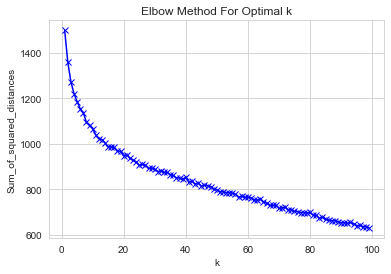

In [67]:
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=1)
    km = km.fit(C_vec)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [85]:
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
  
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 

In [86]:
n_clusters = 18
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=1,random_state = 0)
km = km.fit(C_vec_tfidf)
CountFrequency(list(km.labels_))

 7 :  26
 6 :  22
 14 :  17
 9 :  44
 0 :  41
 4 :  36
 15 :  17
 2 :  26
 5 :  15
 3 :  14
 11 :  20
 8 :  15
 16 :  24
 10 :  23
 13 :  29
 17 :  10
 1 :  19
 12 :  30


In [87]:
Cluster_Cvec= pd.DataFrame(np.c_[km.labels_,df_new])
Cluster_Cvec.columns = ['Cluster','manuscript number', 'Cluster_old', 'Poster', 'ID', 'Status',
       'Abstract Title', 'Last Name', 'First Name', 'Abstract',
       'Email Contact', 'Topic1', 'Topic2', 'Topic3', 'Keyword1', 'Keyword2',
       'Keyword3', 'Evaulator 1 Rating', 'Evaluator 1 Comments',
       'Evaulator 2 Rating', 'Evaluator 2 Comments', 'Evaluator 3 Rating',
       'Evaluator 3 Comments', 'Evaluator 4 Rating', 'Evaluator 4 Comments',
       'Evaluator 5 Rating', 'Evaluator 5 Comments', 'Evaluator 6 Rating',
       'Evaluator 6  Comments','mean_rating']
Cluster_Cvec.head()

,Cluster,manuscript number,Cluster_old,Poster,ID,Status,Abstract Title,Last Name,First Name,Abstract,...,Evaluator 2 Comments,Evaluator 3 Rating,Evaluator 3 Comments,Evaluator 4 Rating,Evaluator 4 Comments,Evaluator 5 Rating,Evaluator 5 Comments,Evaluator 6 Rating,Evaluator 6 Comments,mean_rating
0,7,NaN,20,NaN,13,NaN,Risk And Time Preferences For Consumersâ€™ Cho...,Zhu,Jingrong,Mass penetration of electric vehicles into the...,...,Speaks to an interesting technology adoption i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5
1,6,NaN,22,NaN,16,Under Review Paper,How To Overcome Online Banner Blindness? A Stu...,Yang,Qiang,Creativity matters for attracting consumer att...,...,Seems to a purely analytic paper on a well-wor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
2,14,NaN,22,NaN,20,Working Paper,Research On The Influence Of Digital Presentat...,Jiang,LI,This experiment uses 2 (digital presentation f...,...,A purely conceptual paper could make for a bor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
3,9,NaN,23,NaN,23,Working Paper,Research On The Influence Of Marketing Capabil...,Hongmin,Jin,Whether firms' marketing capability predicts f...,...,The title does not match the content of the ab...,NaN,This is a well-trodden (though important) fiel...,3,NaN,NaN,NaN,NaN,NaN,2.33333
4,0,NaN,22,NaN,25,Under Review Paper,Adopting Cost Transparency As A Marketing Stra...,Lim,Wei-Shi,Should sellers disclose their cost information...,...,There conceptualizatiion focuses on geography...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5


## Visualization

In [88]:
Cluster_all_words = pd.DataFrame(np.c_[km.labels_,full_docs_frame],columns = ['Cluster','All_words','ID'])
cluster_all_str = [] 
for i in range(n_clusters):
    i_list = list(Cluster_all_words[Cluster_all_words['Cluster']==i]['All_words'])
    i_str = " ".join(i_list)
    cluster_all_str.append(i_str)

In [89]:
w_str = []
for i in range(n_clusters):
    w = [w.replace('product','').replace('data','').replace('consumer',' ') for w in word_tokenize(cluster_all_str[i])]
    w_str.append(" ".join(w))

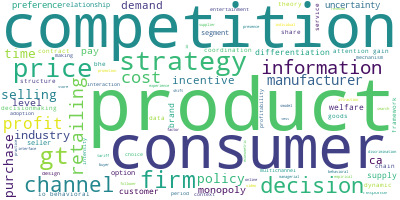

In [90]:
from wordcloud import WordCloud
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud

wordcloud.generate(cluster_all_str[0])

# Visualize the word cloud
wordcloud.to_image()

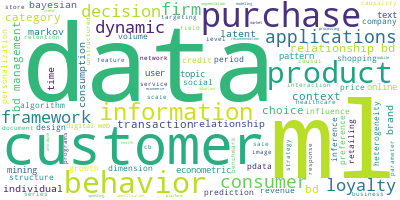

In [91]:
wordcloud.generate(cluster_all_str[1])

# Visualize the word cloud
wordcloud.to_image()

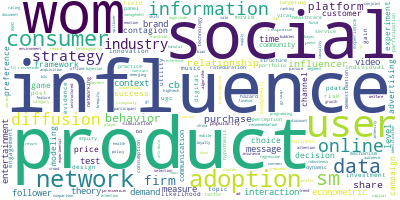

In [92]:
wordcloud.generate(cluster_all_str[2])

# Visualize the word cloud
wordcloud.to_image()

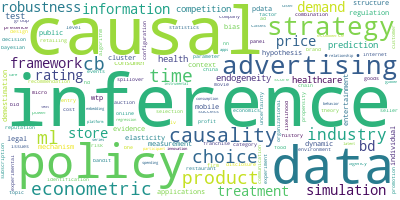

In [93]:
wordcloud.generate(cluster_all_str[3])

# Visualize the word cloud
wordcloud.to_image()

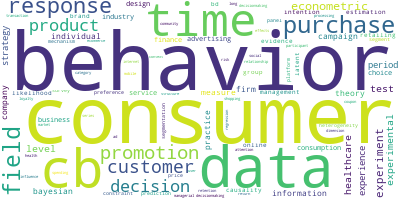

In [94]:
wordcloud.generate(cluster_all_str[4])

# Visualize the word cloud
wordcloud.to_image()

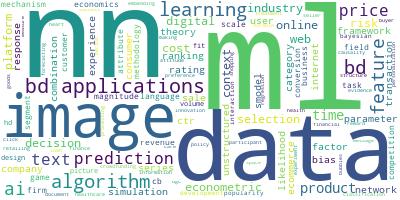

In [95]:
wordcloud.generate(cluster_all_str[5])

# Visualize the word cloud
wordcloud.to_image()

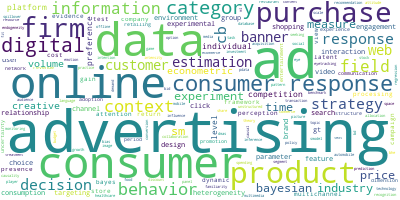

In [96]:
wordcloud.generate(cluster_all_str[6])

# Visualize the word cloud
wordcloud.to_image()

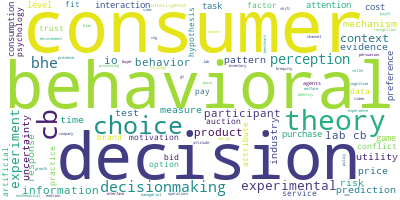

In [97]:
wordcloud.generate(cluster_all_str[7])

# Visualize the word cloud
wordcloud.to_image()

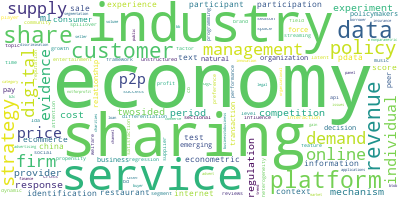

In [98]:
wordcloud.generate(cluster_all_str[8])

# Visualize the word cloud
wordcloud.to_image()

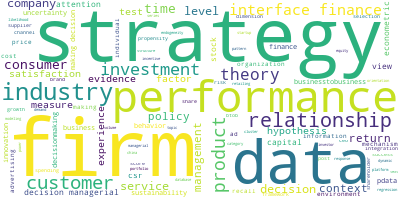

In [99]:
wordcloud.generate(cluster_all_str[9])

# Visualize the word cloud
wordcloud.to_image()

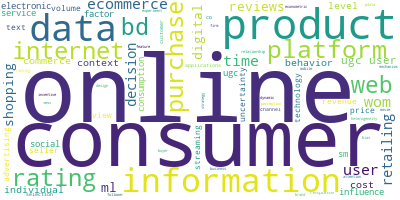

In [100]:
wordcloud.generate(cluster_all_str[10])

# Visualize the word cloud
wordcloud.to_image()

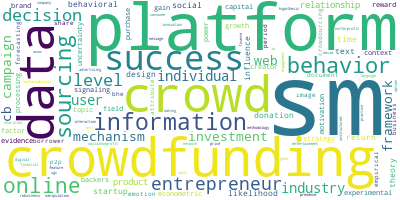

In [101]:
wordcloud.generate(cluster_all_str[11])

# Visualize the word cloud
wordcloud.to_image()

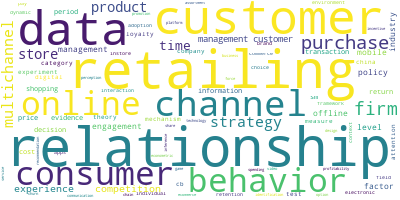

In [102]:
wordcloud.generate(cluster_all_str[12])

# Visualize the word cloud
wordcloud.to_image()

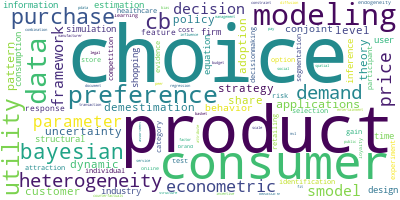

In [103]:
wordcloud.generate(cluster_all_str[13])

# Visualize the word cloud
wordcloud.to_image()

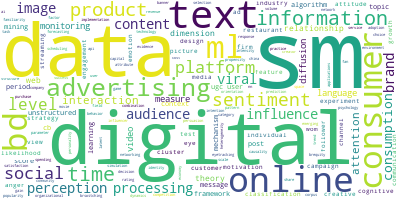

In [104]:
wordcloud.generate(cluster_all_str[14])

# Visualize the word cloud
wordcloud.to_image()

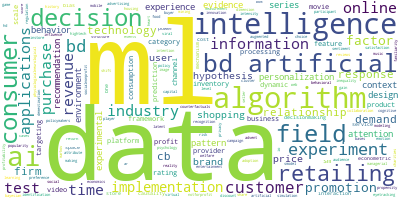

In [105]:
wordcloud.generate(cluster_all_str[15])

# Visualize the word cloud
wordcloud.to_image()

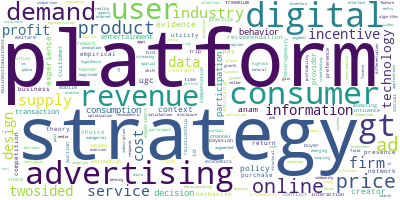

In [106]:
wordcloud.generate(cluster_all_str[16])

# Visualize the word cloud
wordcloud.to_image()

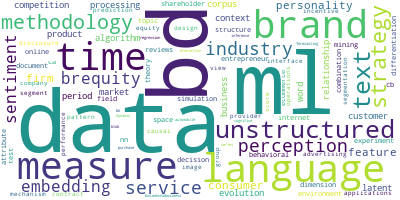

In [107]:
wordcloud.generate(cluster_all_str[17])

# Visualize the word cloud
wordcloud.to_image()

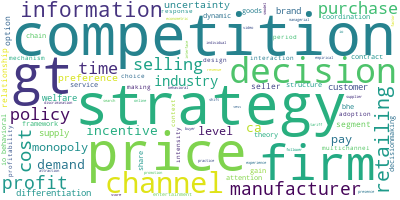

In [110]:
wordcloud.generate(w_str[0])

# Visualize the word cloud
wordcloud.to_image()

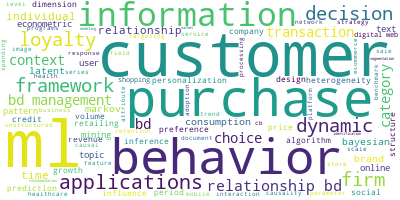

In [111]:
wordcloud.generate(w_str[1])

# Visualize the word cloud
wordcloud.to_image()

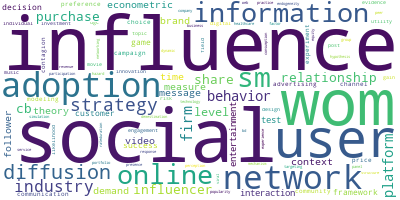

In [112]:
wordcloud.generate(w_str[2])

# Visualize the word cloud
wordcloud.to_image()

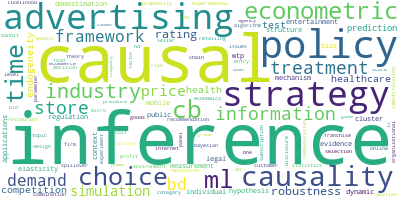

In [113]:
wordcloud.generate(w_str[3])

# Visualize the word cloud
wordcloud.to_image()

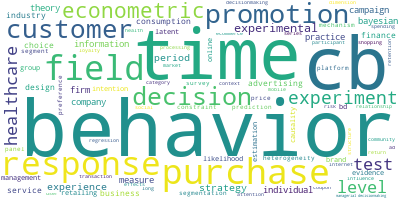

In [114]:
wordcloud.generate(w_str[4])

# Visualize the word cloud
wordcloud.to_image()

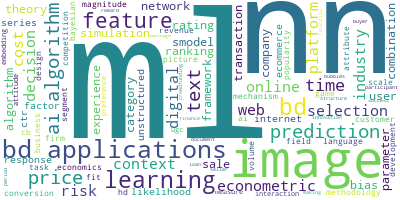

In [115]:
wordcloud.generate(w_str[5])

# Visualize the word cloud
wordcloud.to_image()

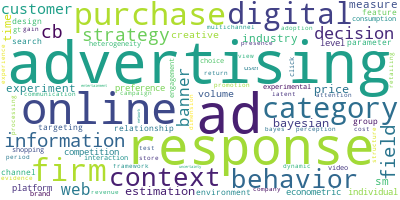

In [116]:
wordcloud.generate(w_str[6])

# Visualize the word cloud
wordcloud.to_image()

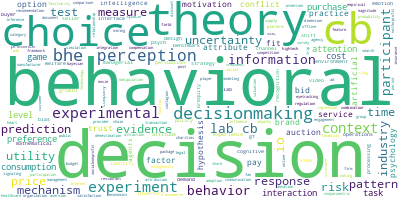

In [117]:
wordcloud.generate(w_str[7])

# Visualize the word cloud
wordcloud.to_image()

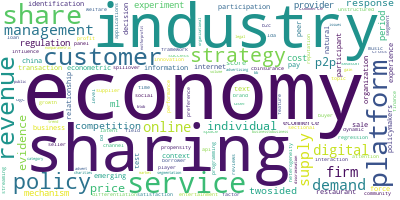

In [118]:
wordcloud.generate(w_str[8])

# Visualize the word cloud
wordcloud.to_image()

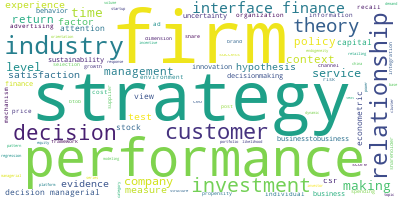

In [119]:
wordcloud.generate(w_str[9])

# Visualize the word cloud
wordcloud.to_image()

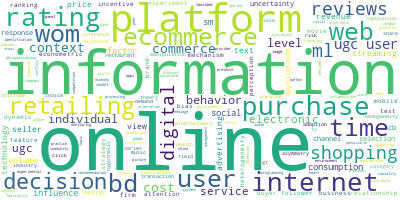

In [120]:
wordcloud.generate(w_str[10])

# Visualize the word cloud
wordcloud.to_image()

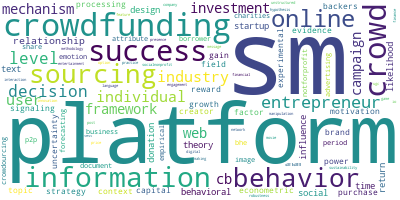

In [121]:
wordcloud.generate(w_str[11])

# Visualize the word cloud
wordcloud.to_image()

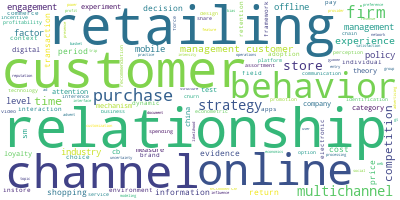

In [122]:
wordcloud.generate(w_str[12])

# Visualize the word cloud
wordcloud.to_image()

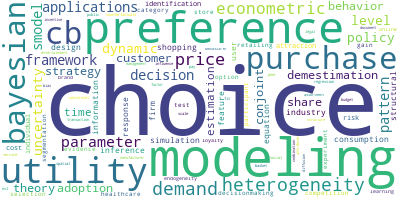

In [123]:
wordcloud.generate(w_str[13])

# Visualize the word cloud
wordcloud.to_image()

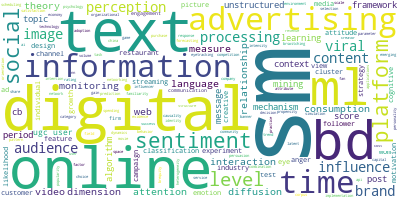

In [124]:
wordcloud.generate(w_str[14])

# Visualize the word cloud
wordcloud.to_image()

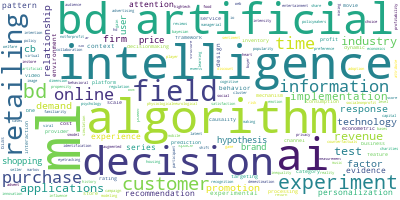

In [125]:
wordcloud.generate(w_str[15])

# Visualize the word cloud
wordcloud.to_image()

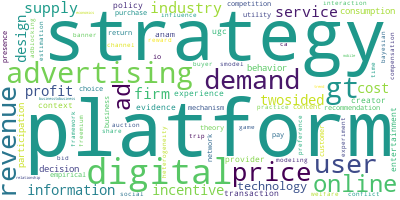

In [126]:
wordcloud.generate(w_str[16])

# Visualize the word cloud
wordcloud.to_image()

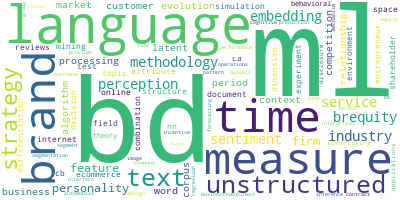

In [127]:
wordcloud.generate(w_str[17])

# Visualize the word cloud
wordcloud.to_image()